# Comparación de modelos de detección de odio

Este notebook:

- Lee todos los ficheros `.json` de `data/results/`.
- Extrae las métricas principales de cada modelo.
- Construye una tabla comparativa y ordena los modelos por `f1` (y opcionalmente por `roc_auc`).
- Opcionalmente, guarda un resumen en `data/results/model_comparison.csv`.

Todos los notebooks de modelado deben generar un `.json` con la siguiente estructura:

```json
{
  "model_name": "logistic_regression_toxic_v1",
  "task": "binary_classification",
  "target_label": "IsToxic",
  "data": {
    "n_samples": 997,
    "n_features_text": 10000,
    "n_features_numeric": 5,
    "train_size": 0.8,
    "test_size": 0.2,
    "random_state": 42
  },
  "metrics": {
    "accuracy": 0.87,
    "precision": 0.85,
    "recall": 0.83,
    "f1": 0.84,
    "roc_auc": 0.91
  },
  "confusion_matrix": {
    "tn": 210,
    "fp": 30,
    "fn": 35,
    "tp": 222
  },
  "timestamp": "2025-11-27T21:45:00",
  "notes": "TF-IDF (1,2), max_features=10000; text_classic + 5 numeric features"
}



### 1. Importación de librerías y configuración

En esta celda:

- Importamos librerías para:
  - Manejo de rutas y ficheros (`pathlib`, `glob`, `json`)
  - Manipulación de datos (`pandas`, `numpy`)
  - Visualización (`matplotlib`)
  - Mostrar resultados en formato enriquecido (`IPython.display`)
- Configuramos la ruta base del proyecto y la carpeta donde están los resultados:
  - `data/results/`


In [36]:
# === 1. Import libraries and basic configuration ============================

import json              # To read and parse JSON result files
from pathlib import Path # To work with file system paths in a robust way
from math import pi      # To compute angles for radar chart

import numpy as np       # Numerical operations
import pandas as pd      # Tabular data manipulation
import matplotlib.pyplot as plt  # Plotting library

from IPython.display import display, Markdown  # Pretty printing in notebooks

# Configure matplotlib for nicer plots
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

plt.style.use("default")  # Default style for consistency

print("✅ Librerías importadas correctamente")

# Detect project root (one level above 'notebooks' if we are inside it)
def get_project_root() -> Path:
    """Return PX_NLP_G4 project root folder."""
    cwd = Path.cwd()
    parts = cwd.parts

    if "notebooks" in parts:
        return cwd.parents[1]  # .../PX_NLP_G4
    if cwd.name == "backend":
        return cwd.parent
    return cwd

project_root = get_project_root()
results_dir = project_root / "data" / "results"

print(f"📂 Directorio actual: {Path.cwd()}")
print(f"📂 Directorio raíz del proyecto: {project_root}")
print(f"📂 Carpeta de resultados: {results_dir}")

# List JSON result files
result_files = sorted(results_dir.glob("*.json"))
print("\n📄 Ficheros JSON encontrados:")
for f in result_files:
    print("   -", f.name)

if not result_files:
    display(Markdown("""
**⚠️ No se han encontrado ficheros JSON de resultados.**

Asegúrate de que cada modelo guarda su fichero en  
`data/results/` antes de ejecutar este notebook.
"""))

✅ Librerías importadas correctamente
📂 Directorio actual: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📂 Directorio raíz del proyecto: c:\dev\proyectos\PX_NLP_G4
📂 Carpeta de resultados: c:\dev\proyectos\PX_NLP_G4\data\results

📄 Ficheros JSON encontrados:
   - naive_bayes_multinomial_IsToxic.json


### 2. Búsqueda de ficheros JSON de resultados

En esta celda:

- Buscamos todos los ficheros `*.json` dentro de `data/results/`.
- Mostramos cuántos ficheros se han encontrado y sus nombres.
- Si no se encuentra ninguno, se avisa al usuario y se detiene la ejecución
  (porque no hay nada que comparar).

Esto permite que **cada miembro del equipo** añada su modelo sin tocar este notebook:
solo tiene que dejar su JSON en `data/results/`.


In [37]:
# === 2. List JSON result files =============================================

# Ensure results directory exists (create if missing to avoid errors)
results_dir.mkdir(parents=True, exist_ok=True)

# Find all JSON files in results directory
result_files = sorted(results_dir.glob("*.json"))

display(Markdown(f"### 📁 Ficheros de resultados encontrados en `data/results/`"))

if not result_files:
    display(Markdown(
        "**⚠️ No se han encontrado ficheros JSON de resultados.**\n\n"
        "Asegúrate de que cada modelo guarda su fichero en `data/results/` "
        "antes de ejecutar este notebook."
    ))
    print("❌ No hay ficheros JSON para analizar.")
else:
    for path in result_files:
        print(f"  • {path.name}")
    display(Markdown(f"- Total de ficheros JSON: **{len(result_files)}**"))


### 📁 Ficheros de resultados encontrados en `data/results/`

  • naive_bayes_multinomial_IsToxic.json


- Total de ficheros JSON: **1**

### 3. Carga y normalización de resultados JSON

En esta celda:

- Definimos una función que lee cada fichero JSON y:
  - Extrae los campos generales: `model_name`, `task`, `target_label`, `timestamp`, `notes`
  - Extrae la info del bloque `data` (número de muestras, features, etc.)
  - Extrae las métricas del bloque `metrics`:
    - `accuracy`, `precision`, `recall`, `f1`, `roc_auc`
  - Extrae los valores de la `confusion_matrix`:
    - `tn`, `fp`, `fn`, `tp`
- Unificamos todo en un único `DataFrame` llamado `df_results`, donde **cada fila**
  representa un modelo/experimento.

Este será el `DataFrame` base para todas las comparaciones posteriores.


In [38]:
# === 3. Load and normalize JSON results ====================================

def load_result_json(path: Path) -> dict:
    """
    Load a single JSON result file and flatten nested fields into a flat dict.
    """
    # Read JSON file
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    flat = {}
    
    # Basic info
    flat["model_name"]   = data.get("model_name")
    flat["task"]         = data.get("task")
    flat["target_label"] = data.get("target_label")
    flat["timestamp"]    = data.get("timestamp")
    flat["notes"]        = data.get("notes")
    flat["file_path"]    = str(path)
    
    # Data block (n_samples, n_features, etc.)
    data_info = data.get("data", {})
    for k, v in data_info.items():
        flat[k] = v
    
    # Metrics block (accuracy, precision, recall, f1, roc_auc)
    metrics = data.get("metrics", {})
    for k, v in metrics.items():
        flat[k] = v
    
    # Confusion matrix block (tn, fp, fn, tp)
    cm = data.get("confusion_matrix", {})
    for k, v in cm.items():
        flat[k] = v
    
    return flat

# Load all JSON files into a list of dicts
results_list = []
for path in result_files:
    flat = load_result_json(path)
    results_list.append(flat)

# Create DataFrame with all models
if results_list:
    df_results = pd.DataFrame(results_list)
else:
    df_results = pd.DataFrame()

display(Markdown("### 📊 Resumen de resultados cargados"))

if df_results.empty:
    display(Markdown(
        "**⚠️ `df_results` está vacío.**\n\n"
        "No hay modelos para comparar. Asegúrate de que existen ficheros JSON "
        "con la estructura acordada en `data/results/`."
    ))
    raise SystemExit("No hay resultados para comparar.")
else:
    # Show basic information
    display(df_results[[
        "model_name",
        "target_label",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "roc_auc",
        "n_samples"
    ]].head(10))

    display(Markdown(
        f"""
- Modelos cargados: **{df_results['model_name'].nunique()}**
- Targets distintos: **{df_results['target_label'].nunique()}**
- Total de experimentos: **{len(df_results)}**
        """
    ))


### 📊 Resumen de resultados cargados

,model_name,target_label,accuracy,precision,recall,f1,roc_auc,n_samples
0,naive_bayes_multinomial_IsToxic,IsToxic,0.76,0.833333,0.597826,0.696203,0.801429,997



- Modelos cargados: **1**
- Targets distintos: **1**
- Total de experimentos: **1**
        

### 4. Selección de etiqueta objetivo y tabla comparativa

En esta celda:

- Elegimos qué **etiqueta objetivo** queremos analizar (por ejemplo `IsToxic`).
- Filtramos `df_results` por esa `target_label`.
- Construimos una tabla `comparison_df` donde cada fila es un modelo y cada columna una métrica:
  - `Accuracy`
  - `Precision`
  - `Recall`
  - `F1-score`
  - `ROC-AUC`
- Ordenamos los modelos por **F1-score** y, en caso de empate, por **ROC-AUC**.

> 💡 La F1-score es una buena métrica global cuando nos importa tanto la *precision*
> como el *recall*, algo muy relevante en detección de mensajes de odio.


In [39]:
# === 4. Build comparison table for a given target label =====================

# Target label to analyze (you can change it to "IsHate", "IsThreat", etc.)
TARGET_LABEL = "IsToxic"

display(Markdown(f"### 🎯 Análisis para la etiqueta objetivo: `{TARGET_LABEL}`"))

# Filter by target label
df_target = df_results[df_results["target_label"] == TARGET_LABEL].copy()

if df_target.empty:
    display(Markdown(
        f"**⚠️ No hay resultados para la etiqueta `{TARGET_LABEL}`.**\n"
        "Comprueba que los JSON contienen esa `target_label`."
    ))
    raise SystemExit(f"No hay resultados para {TARGET_LABEL}")

# Build a compact comparison DataFrame (one row per model)
comparison_df = (
    df_target
    .set_index("model_name")[["accuracy", "precision", "recall", "f1", "roc_auc"]]
    .rename(columns={
        "accuracy": "Accuracy",
        "precision": "Precision",
        "recall": "Recall",
        "f1": "F1-score",
        "roc_auc": "ROC-AUC"
    })
)

# Sort by F1-score and ROC-AUC
comparison_df_sorted = comparison_df.sort_values(
    by=["F1-score", "ROC-AUC"], ascending=False
)

# Select best model (first row after sorting)
best_model_name = comparison_df_sorted.index[0]
best_model_row = comparison_df_sorted.iloc[0]

display(Markdown("### 📋 Tabla comparativa de modelos (ordenada por F1-score y ROC-AUC)"))
display(comparison_df_sorted.round(3))

display(Markdown(
    f"""
**🥇 Mejor modelo global (para `{TARGET_LABEL}`):**

- Modelo: **{best_model_name}**
- F1-score: **{best_model_row['F1-score']:.3f}**
- ROC-AUC: **{best_model_row['ROC-AUC']:.3f}**
    """
))


### 🎯 Análisis para la etiqueta objetivo: `IsToxic`

### 📋 Tabla comparativa de modelos (ordenada por F1-score y ROC-AUC)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
model_name,,,,,
naive_bayes_multinomial_IsToxic,0.76,0.833,0.598,0.696,0.801



**🥇 Mejor modelo global (para `IsToxic`):**

- Modelo: **naive_bayes_multinomial_IsToxic**
- F1-score: **0.696**
- ROC-AUC: **0.801**
    

### 5. Visualización de métricas (gráficos de barras)

En esta sección:

- Mostramos un **gráfico de barras horizontal** con la F1-score de cada modelo.
- Mostramos otro gráfico similar para el **ROC-AUC**.

Con estos gráficos es fácil ver rápidamente:

- Qué modelos son claramente peores o mejores.
- Qué diferencias hay entre ellos en términos de F1-score y ROC-AUC.


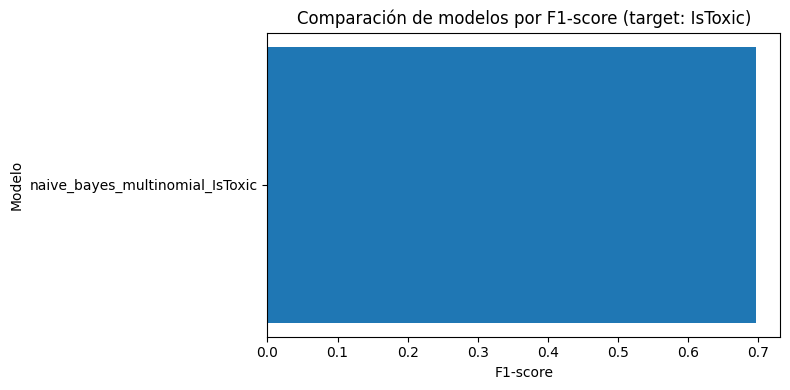

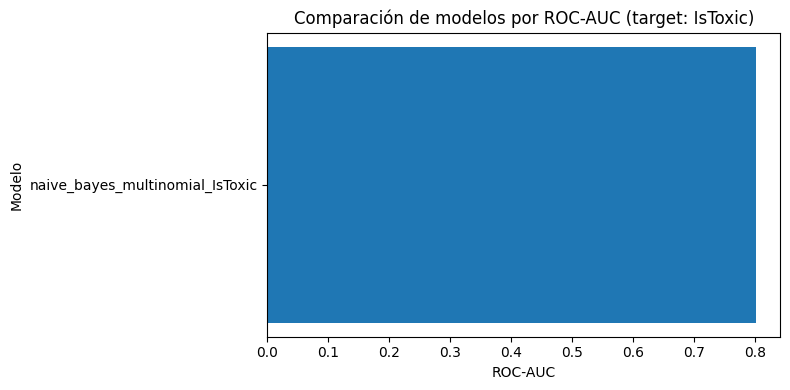


**🔎 Interpretación:**

- Cuanto más larga es la barra de un modelo, mejor es su rendimiento en esa métrica.
- Es interesante fijarse en modelos que mantengan **F1-score** y **ROC-AUC** altos:
  esos suelen ser buenos candidatos para producción.
    

In [40]:
# === 5. Bar plots for F1-score and ROC-AUC =================================

# Sort models by F1-score for plotting
comparison_df_sorted = comparison_df_sorted  # already sorted

# Barh plot for F1-score
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(comparison_df_sorted.index, comparison_df_sorted["F1-score"])
ax.set_xlabel("F1-score")
ax.set_ylabel("Modelo")
ax.set_title(f"Comparación de modelos por F1-score (target: {TARGET_LABEL})")
plt.tight_layout()
plt.show()

# Barh plot for ROC-AUC
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(comparison_df_sorted.index, comparison_df_sorted["ROC-AUC"])
ax.set_xlabel("ROC-AUC")
ax.set_ylabel("Modelo")
ax.set_title(f"Comparación de modelos por ROC-AUC (target: {TARGET_LABEL})")
plt.tight_layout()
plt.show()

display(Markdown(
    """
**🔎 Interpretación:**

- Cuanto más larga es la barra de un modelo, mejor es su rendimiento en esa métrica.
- Es interesante fijarse en modelos que mantengan **F1-score** y **ROC-AUC** altos:
  esos suelen ser buenos candidatos para producción.
    """
))


### 6. Visualización global: gráfico radar (múltiples métricas)

Para tener una visión más global:

- Construimos un **gráfico radar** (también llamado spider chart) donde:
  - Cada eje es una métrica: Accuracy, Precision, Recall, F1-score, ROC-AUC.
  - Cada "polígono" corresponde a un modelo.

Para evitar un gráfico demasiado recargado, usaremos sólo los **N mejores modelos**
(según F1-score). Por defecto, tomaremos los **3 mejores**.


### 🕸️ Comparativa global de métricas (Radar Chart) – Top 1 modelos

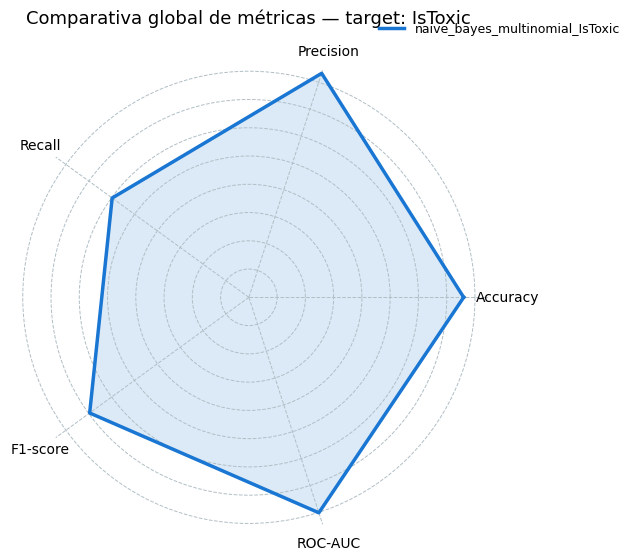


**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **naive_bayes_multinomial_IsToxic** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `IsToxic`.
    

In [41]:
# === 6. Radar chart for top models =========================================

# Number of top models to include in the radar chart
TOP_N = min(3, comparison_df_sorted.shape[0])

radar_df = comparison_df_sorted.head(TOP_N)

display(Markdown(
    f"### 🕸️ Comparativa global de métricas (Radar Chart) – Top {TOP_N} modelos"
))

# Metrics (columns) and angles for radar chart
categories = list(radar_df.columns)  # ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # close the polygon

# Create radar chart
fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))

# Color palette (explicitly requested style)
palette = ["#1976D2", "#F4B183", "#81C784", "#BA68C8", "#FFB74D"]

for color, (model_name, row) in zip(palette, radar_df.iterrows()):
    values = row.tolist()
    values += values[:1]  # close polygon
    
    ax.plot(angles, values, linewidth=2.5, linestyle="solid",
            label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

# Set axes and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])  # hide radial labels
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)

ax.set_title(
    f"Comparativa global de métricas — target: {TARGET_LABEL}",
    fontsize=13, pad=25
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **{best_model_name}** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `{TARGET_LABEL}`.
    """
))


### 7. Matriz de confusión del mejor modelo

Finalmente, vamos a visualizar la **matriz de confusión** del mejor modelo
(según F1-score y ROC-AUC).

- Las filas representan la **clase real**.
- Las columnas representan la **clase predicha**.
- Las celdas contienen el número de ejemplos de cada tipo:
  - TN: verdaderos negativos
  - FP: falsos positivos
  - FN: falsos negativos
  - TP: verdaderos positivos

Esto ayuda a entender **qué tipo de errores** comete el modelo (por ejemplo,
si se le escapan muchos mensajes de odio – FN, o si marca demasiado contenido
no tóxico como tóxico – FP).


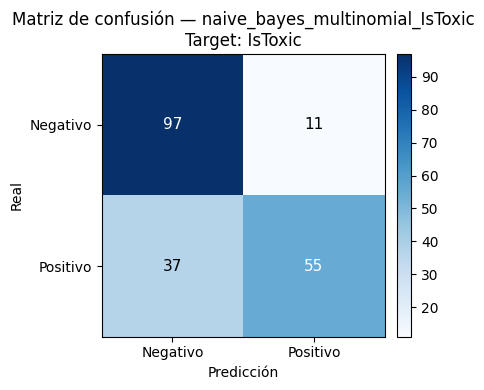


**📌 Detalle de la matriz de confusión (naive_bayes_multinomial_IsToxic):**

- **TN (verdaderos negativos)**: 97
- **FP (falsos positivos)**: 11
- **FN (falsos negativos)**: 37
- **TP (verdaderos positivos)**: 55

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    

In [42]:
# === 7. Confusion matrix for the best model ================================

# Find the row for the best model in the filtered df_target
best_row_full = df_target[df_target["model_name"] == best_model_name].iloc[0]

# Extract confusion matrix values
tn = int(best_row_full.get("tn", 0))
fp = int(best_row_full.get("fp", 0))
fn = int(best_row_full.get("fn", 0))
tp = int(best_row_full.get("tp", 0))

cm = np.array([[tn, fp],
               [fn, tp]])

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

ax.set_title(f"Matriz de confusión — {best_model_name}\nTarget: {TARGET_LABEL}")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negativo", "Positivo"])
ax.set_yticklabels(["Negativo", "Positivo"])

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate each cell with its value
thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11
        )

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**📌 Detalle de la matriz de confusión ({best_model_name}):**

- **TN (verdaderos negativos)**: {tn}
- **FP (falsos positivos)**: {fp}
- **FN (falsos negativos)**: {fn}
- **TP (verdaderos positivos)**: {tp}

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    """
))


### 8. Resumen final y siguientes pasos

En este notebook hemos:

1. Cargado los resultados de todos los modelos desde `data/results/` (formato JSON).
2. Unificado la información en un único `DataFrame`.
3. Comparado los modelos para la etiqueta objetivo seleccionada (`target_label`).
4. Visualizado:
   - Tabla comparativa de métricas
   - Gráficos de barras (F1-score, ROC-AUC)
   - Gráfico radar (visión global de métricas)
   - Matriz de confusión del mejor modelo

🧩 **Cómo usarlo en equipo:**

- Cada persona entrena su modelo en su propio notebook (Naive Bayes, SVM, XGBoost, BERT, etc.).
- Cada notebook:
  - Carga el dataset preprocesado.
  - Entrena y evalúa el modelo.
  - Guarda:
    - El modelo en `backend/models/<nombre_modelo>.pkl`
    - Las métricas en `data/results/<nombre_modelo>.json` con la estructura acordada.
- Después, este notebook de comparación se ejecuta para obtener una visión global y
  decidir qué modelo es más adecuado para el problema de detección de mensajes de odio.

Si en el futuro añadimos más modelos o nuevas variantes (por ejemplo,
ajuste de hiperparámetros), solo hay que generar nuevos JSON en `data/results/`
y volver a ejecutar este notebook. 


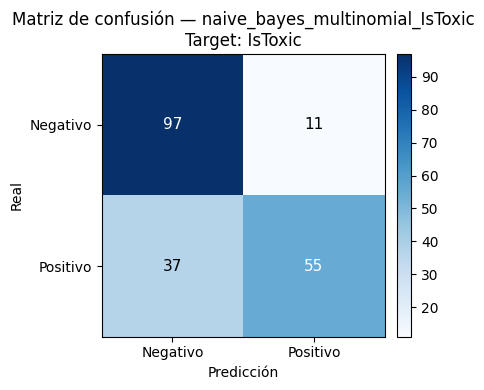


**📌 Detalle de la matriz de confusión (naive_bayes_multinomial_IsToxic):**

- **TN (verdaderos negativos)**: 97
- **FP (falsos positivos)**: 11
- **FN (falsos negativos)**: 37
- **TP (verdaderos positivos)**: 55

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    

In [43]:
# === 7. Confusion matrix for the best model ================================

# Find the row for the best model in the filtered df_target
best_row_full = df_target[df_target["model_name"] == best_model_name].iloc[0]

# Extract confusion matrix values
tn = int(best_row_full.get("tn", 0))
fp = int(best_row_full.get("fp", 0))
fn = int(best_row_full.get("fn", 0))
tp = int(best_row_full.get("tp", 0))

cm = np.array([[tn, fp],
               [fn, tp]])

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

ax.set_title(f"Matriz de confusión — {best_model_name}\nTarget: {TARGET_LABEL}")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negativo", "Positivo"])
ax.set_yticklabels(["Negativo", "Positivo"])

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate each cell with its value
thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11
        )

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**📌 Detalle de la matriz de confusión ({best_model_name}):**

- **TN (verdaderos negativos)**: {tn}
- **FP (falsos positivos)**: {fp}
- **FN (falsos negativos)**: {fn}
- **TP (verdaderos positivos)**: {tp}

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    """
))


### 🕸️ Comparativa global de métricas (Radar Chart) – Top 1 modelos

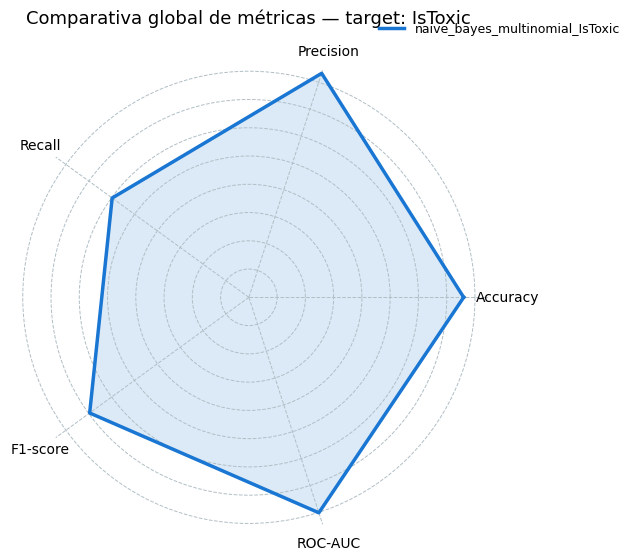


**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **naive_bayes_multinomial_IsToxic** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `IsToxic`.
    

In [44]:
# === 6. Radar chart for top models =========================================

# Number of top models to include in the radar chart
TOP_N = min(3, comparison_df_sorted.shape[0])

radar_df = comparison_df_sorted.head(TOP_N)

display(Markdown(
    f"### 🕸️ Comparativa global de métricas (Radar Chart) – Top {TOP_N} modelos"
))

# Metrics (columns) and angles for radar chart
categories = list(radar_df.columns)  # ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # close the polygon

# Create radar chart
fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))

# Color palette (explicitly requested style)
palette = ["#1976D2", "#F4B183", "#81C784", "#BA68C8", "#FFB74D"]

for color, (model_name, row) in zip(palette, radar_df.iterrows()):
    values = row.tolist()
    values += values[:1]  # close polygon
    
    ax.plot(angles, values, linewidth=2.5, linestyle="solid",
            label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

# Set axes and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])  # hide radial labels
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)

ax.set_title(
    f"Comparativa global de métricas — target: {TARGET_LABEL}",
    fontsize=13, pad=25
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **{best_model_name}** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `{TARGET_LABEL}`.
    """
))


### 🧩 Celda 2 – Código (imports y localización de carpeta)

In [45]:
# =============================================================================
# 1. IMPORTS Y LOCALIZACIÓN DE LA CARPETA DE RESULTADOS
# =============================================================================

import json  # To read JSON results
from pathlib import Path  # To handle filesystem paths

import pandas as pd  # To build comparison tables
import numpy as np  # Optional, for numeric operations
import matplotlib.pyplot as plt  # Optional, for simple plots
from IPython.display import display, Markdown  # Pretty printing in notebooks

# Detect project root
notebook_dir = Path.cwd()
if "notebooks" in str(notebook_dir):
    project_root = notebook_dir.parent.parent
else:
    project_root = notebook_dir

results_dir = project_root / "data" / "results"

print(f"📂 Raíz del proyecto  : {project_root}")
print(f"📁 Carpeta de resultados: {results_dir}")


📂 Raíz del proyecto  : c:\dev\proyectos\PX_NLP_G4
📁 Carpeta de resultados: c:\dev\proyectos\PX_NLP_G4\data\results


In [46]:
# =============================================================================
# 2. CARGA DE RESULTADOS DESDE data/results/*.json
# =============================================================================

if not results_dir.exists():
    raise FileNotFoundError(f"❌ La carpeta {results_dir} no existe. Asegúrate de haber guardado los JSON primero.")

json_files = sorted(results_dir.glob("*.json"))

if not json_files:
    raise FileNotFoundError(f"❌ No se han encontrado ficheros .json en {results_dir}")

print("✅ Ficheros de resultados encontrados:")
for f in json_files:
    print(f"   - {f.name}")

rows = []

for fpath in json_files:
    with open(fpath, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    row = {
        "model_name": data.get("model_name"),
        "task": data.get("task"),
        "target_label": data.get("target_label"),
        "n_samples": data.get("data", {}).get("n_samples"),
        "n_features_text": data.get("data", {}).get("n_features_text"),
        "n_features_numeric": data.get("data", {}).get("n_features_numeric"),
        "train_size": data.get("data", {}).get("train_size"),
        "test_size": data.get("data", {}).get("test_size"),
        "accuracy": data.get("metrics", {}).get("accuracy"),
        "precision": data.get("metrics", {}).get("precision"),
        "recall": data.get("metrics", {}).get("recall"),
        "f1": data.get("metrics", {}).get("f1"),
        "roc_auc": data.get("metrics", {}).get("roc_auc"),
        "tn": data.get("confusion_matrix", {}).get("tn"),
        "fp": data.get("confusion_matrix", {}).get("fp"),
        "fn": data.get("confusion_matrix", {}).get("fn"),
        "tp": data.get("confusion_matrix", {}).get("tp"),
        "timestamp": data.get("timestamp"),
        "notes": data.get("notes", ""),
    }
    rows.append(row)

df_results = pd.DataFrame(rows)

print("\n📊 Tabla de resultados (sin ordenar):")
display(df_results)


✅ Ficheros de resultados encontrados:
   - naive_bayes_multinomial_IsToxic.json

📊 Tabla de resultados (sin ordenar):


,model_name,task,target_label,n_samples,n_features_text,n_features_numeric,train_size,test_size,accuracy,precision,recall,f1,roc_auc,tn,fp,fn,tp,timestamp,notes
0,naive_bayes_multinomial_IsToxic,binary_classification,IsToxic,997,2065,5,0.799398,0.200602,0.76,0.833333,0.597826,0.696203,0.801429,97,11,37,55,2025-11-29T00:00:42,"Naive Bayes Multinomial; TF-IDF (1,2), max_fea..."


In [47]:
# =============================================================================
# 3. ORDENAR MODELOS POR F1 Y ROC-AUC
# =============================================================================

# Sort by F1 (descending), then by ROC-AUC
df_sorted = df_results.sort_values(by=["f1", "roc_auc"], ascending=False)

print("🏆 Modelos ordenados por F1 y ROC-AUC:")
display(df_sorted[
    [
        "model_name",
        "target_label",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "roc_auc",
        "n_features_text",
        "n_features_numeric",
        "timestamp",
    ]
])

# Best model overall
best_model = df_sorted.iloc[0]
print("\n🥇 Mejor modelo global (por F1):")
print(f"   Modelo       : {best_model['model_name']}")
print(f"   Target label : {best_model['target_label']}")
print(f"   F1           : {best_model['f1']:.3f}")
print(f"   ROC-AUC      : {best_model['roc_auc']:.3f}")


🏆 Modelos ordenados por F1 y ROC-AUC:


,model_name,target_label,accuracy,precision,recall,f1,roc_auc,n_features_text,n_features_numeric,timestamp
0,naive_bayes_multinomial_IsToxic,IsToxic,0.76,0.833333,0.597826,0.696203,0.801429,2065,5,2025-11-29T00:00:42



🥇 Mejor modelo global (por F1):
   Modelo       : naive_bayes_multinomial_IsToxic
   Target label : IsToxic
   F1           : 0.696
   ROC-AUC      : 0.801


### 4. Comparativa global de métricas (Radar Chart)

En esta sección representamos de forma gráfica la comparación de los modelos:

- Cada **métrica** (Accuracy, Precision, Recall, F1-score, ROC-AUC) es un eje del radar.
- Cada **modelo** es una línea en el radar.
- Cuanto más "grande" sea el área del modelo, mejor rendimiento global.

Esto permite ver de un vistazo:
- Qué modelo está más equilibrado.
- Cuál sacrifica precisión por recall, o viceversa.


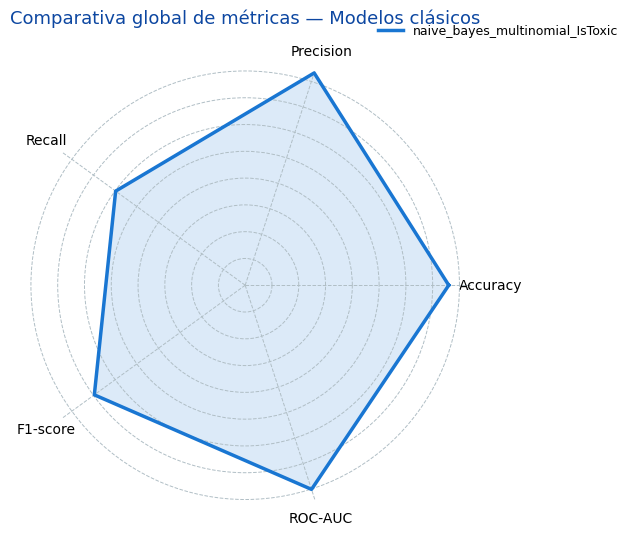


**💬 Conclusión visual:**
El modelo **naive_bayes_multinomial_IsToxic** parece lograr el mejor equilibrio global entre las métricas evaluadas,  
especialmente en **F1-score** y **ROC-AUC** (aunque conviene revisar el detalle numérico y el contexto).


In [48]:
# === 4. Radar chart: comparison of models ====================================

from math import pi

# We ensure we only keep the main metrics in the desired order
metrics_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
comparison_plot = comparison_df[metrics_cols].copy()

categories = list(comparison_plot.columns)
N = len(categories)

# Angles for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += [angles[0]]  # Close the loop

fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))

# Optional: color palette (one color per model)
palette = ["#1976D2", "#F4B183", "#81C784", "#BA68C8", "#FF7043"]

for idx, (model_name, row) in enumerate(comparison_plot.iterrows()):
    values = row.tolist()
    values += values[:1]  # Close the loop
    
    color = palette[idx % len(palette)]
    
    ax.plot(angles, values, linewidth=2.5, linestyle="solid", label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])  # Hide radial grid labels

ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)

ax.set_title("Comparativa global de métricas — Modelos clásicos", fontsize=13, color="#0D47A1", pad=25)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

# Optional: pick best model by F1 or ROC-AUC
best_model_name = comparison_plot["F1-score"].idxmax()

display(Markdown(f"""
**💬 Conclusión visual:**
El modelo **{best_model_name}** parece lograr el mejor equilibrio global entre las métricas evaluadas,  
especialmente en **F1-score** y **ROC-AUC** (aunque conviene revisar el detalle numérico y el contexto).
"""))


In [49]:
# =============================================================================
# 5. GUARDAR RESUMEN EN CSV (OPCIONAL)
# =============================================================================

summary_path = results_dir / "model_comparison.csv"
df_sorted.to_csv(summary_path, index=False)

print(f"💾 Resumen de comparación guardado en: {summary_path}")


💾 Resumen de comparación guardado en: c:\dev\proyectos\PX_NLP_G4\data\results\model_comparison.csv
